Import all necessary libraries and install everything you need for training:

In [1]:
# install the libraries necessary for data wrangling, prediction and result analysis
import json
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score,precision_score, recall_score
import torch
from numba import cuda
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

In [2]:
# Install transformers
# (this needs to be done on Kaggle each time you start the session)
#!pip install -q transformers

In [2]:
# Install the simpletransformers
#!pip install -q simpletransformers
from simpletransformers.classification import ClassificationModel

In [4]:
# Install wandb
#!pip install -q wandb

In [3]:
import wandb

In [4]:
# Login to wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tajak (use `wandb login --relogin` to force relogin)


True

In [5]:
# Clean the GPU cache

cuda.select_device(0)
cuda.close()
cuda.select_device(0)
torch.cuda.empty_cache()


### Import the data

In [6]:
# GINCO full set (all labels except the labels with less than 10 instances)
train_df = pd.read_csv("data-splits/GINCO-full-set-train.csv", index_col = 0)
dev_df = pd.read_csv("data-splits/GINCO-full-set-dev.csv", index_col = 0)
test_df = pd.read_csv("data-splits/GINCO-full-set-test.csv", index_col = 0)

print("GINCO train shape: {}, Dev shape: {}, Test shape: {}.".format(train_df.shape, dev_df.shape, test_df.shape))

GINCO train shape: (579, 2), Dev shape: (193, 2), Test shape: (193, 2).


In [7]:
train_df.head()

,text,labels
680,CD PREDVAJALNIK <p/> CD predvajalnik <p/> CD p...,Promotion of a Product
769,Objavljeno: 20 Mar 2010 13:08 Naslov sporočila...,Forum
613,Nazadnje urejal/a kaela 19 Nov 2011 19:16; sku...,Forum
931,Katero hrano je dobro jesti skupaj in katero n...,Instruction
485,"Narišem navpično črto, vzporedno z levim robom...",Instruction


## Testing

We will use the multilingual XLM-RoBERTa model
https://huggingface.co/xlm-roberta-base

In [10]:
# Create a file to save results into (you can find it under Data: Output). Be careful, run this step only once to not overwrite the results file.
#results = []

#with open("results/FTD-Experiments-Results.json", "w") as results_file:
#    json.dump(results,results_file, indent= "")

In [8]:
# Open the main results file:

previous_results_file = open("results/GINCO-Experiments-Results.json")
previous_results = json.load(previous_results_file)
len(previous_results)

5

In [9]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [10]:
# Create a list of labels
LABELS = train_df.labels.unique().tolist()
LABELS

['Promotion of a Product',
 'Forum',
 'Instruction',
 'News/Reporting',
 'Opinionated News',
 'Other',
 'List of Summaries/Excerpts',
 'Invitation',
 'Opinion/Argumentation',
 'Legal/Regulation',
 'Information/Explanation',
 'Review',
 'Promotion of Services',
 'Promotion',
 'Announcement',
 'Call',
 'Correspondence']

In [11]:
# Initialize Wandb
run = wandb.init(project="GINCO-hyperparameter-search", entity="tajak", name="testing-trained-model")

In [12]:
# Load the saved model
#artifact = run.use_artifact('tajak/GINCO-hyperparameter-search/GINCO-full-set-classifier:v0', type='model')
#artifact_dir = artifact.download()

# Loading a local save
model = ClassificationModel(
    "xlmroberta", "artifacts/GINCO-full-set-classifier:v0")

/home/tajak/anaconda3/lib/python3.9/site-packages/simpletransformers/classification/classification_model.py:459: UserWarning: use_multiprocessing automatically disabled as xlmroberta fails when using multiprocessing for feature conversion.
  warnings.warn(


In [13]:
def testing(test_df, test_name):
    """
    This function takes the test dataset and applies the trained model on it to infer predictions.
    It also prints and saves a confusion matrix, calculates the F1 scores and saves the results in a list of results.

    Args:
    - test_df (pandas DataFrame)
    - test_name
    """
    # Get the true labels
    y_true = test_df.labels
    
    # Calculate the model's predictions on test
    def make_prediction(input_string):
        return model.predict([input_string])[0][0]

    y_pred = test_df.text.apply(make_prediction)
    test_df["y_pred_GINCO_full_set"] = y_pred

    # Calculate the scores
    macro = f1_score(y_true, y_pred, labels=LABELS, average="macro")
    micro = f1_score(y_true, y_pred, labels=LABELS,  average="micro")
    print(f"Macro f1: {macro:0.3}, Micro f1: {micro:0.3}")

    # Plot the confusion matrix:
    cm = confusion_matrix(y_true, y_pred, labels=LABELS)
    plt.figure(figsize=(9, 9))
    plt.imshow(cm, cmap="Oranges")
    for (i, j), z in np.ndenumerate(cm):
        plt.text(j, i, '{:d}'.format(z), ha='center', va='center')
    classNames = LABELS
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=90)
    plt.yticks(tick_marks, classNames)
    plt.title(f"{test_name}")

    plt.tight_layout()
    fig1 = plt.gcf()
    plt.show()
    plt.draw()
    fig1.savefig(f"figures/Confusion-matrix-{test_name}.png",dpi=100)

    # Save the results:
    rezdict = {
        "experiment": test_name,
        "num_train_epochs": 20,
        "train_batch_size":8,
        "learning_rate": 1e-5,
        "microF1": micro,
        "macroF1": macro,
        "y_true": y_true.to_dict(),
        "y_pred": y_pred.to_dict(),
        }
    previous_results.append(rezdict)

    #Save intermediate results (just in case)
    backup = []
    backup.append(rezdict)
    with open(f"backup-results-{test_name}.json", "w") as backup_file:
        json.dump(backup,backup_file, indent= "")

    # Save the new dataframe which contains the y_pred values as well
    test_df.to_csv(f"results/{test_name}-sheet-with-predictions.csv", sep="\t")

Macro f1: 0.539, Micro f1: 0.668


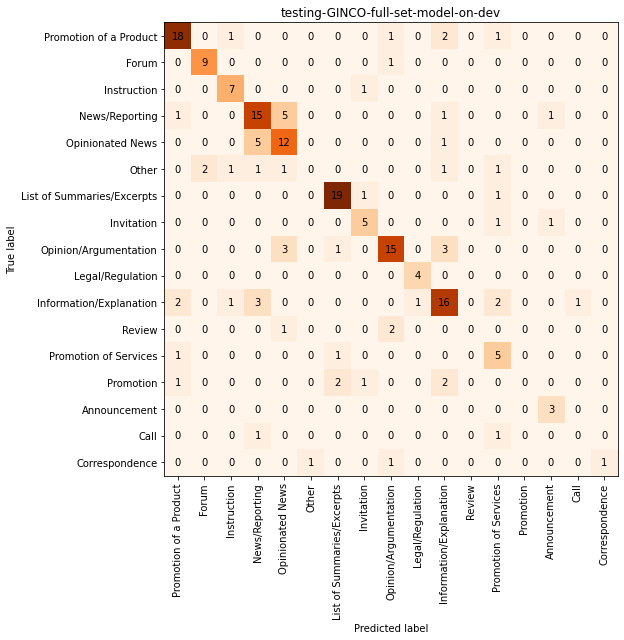


Testing finished.


<Figure size 432x288 with 0 Axes>

In [14]:
testing(dev_df, "testing-GINCO-full-set-model-on-dev")

print("\nTesting finished.")

Macro f1: 0.466, Micro f1: 0.591


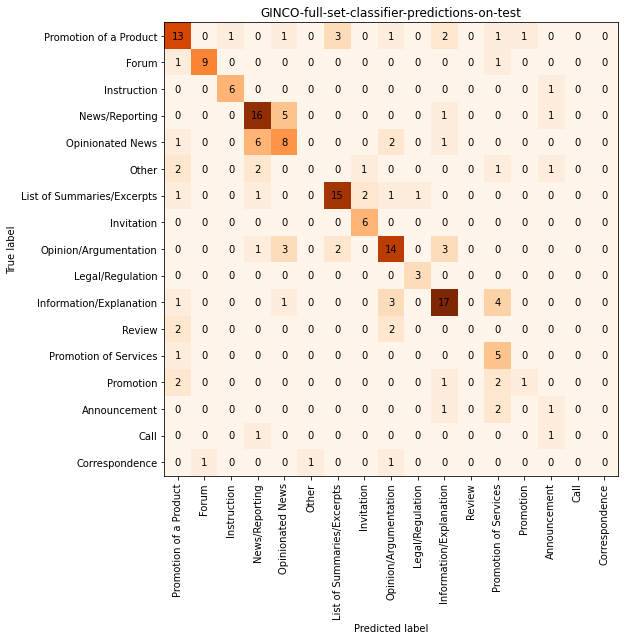


Testing finished.


<Figure size 432x288 with 0 Axes>

In [17]:
testing(test_df, "GINCO-full-set-classifier-predictions-on-test")
print("\nTesting finished.")

In [18]:
# Compare the results by creating a dataframe from the previous_results dictionary:
results_df = pd.DataFrame(previous_results)

results_df

,experiment,num_train_epochs,train_batch_size,learning_rate,microF1,macroF1,y_true,y_pred
0,Dev-epoch-search:1,1,8,0.00001,0.238342,0.085359,"{'245': 'Call', '143': 'Invitation', '146': 'N...","{'245': 'News/Reporting', '143': 'Information/..."
1,Dev-epoch-search:12,12,8,0.00001,0.585492,0.417602,"{'245': 'Call', '143': 'Invitation', '146': 'N...","{'245': 'News/Reporting', '143': 'Invitation',..."
2,Dev-epoch-search:15,15,8,0.00001,0.658031,0.504828,"{'245': 'Call', '143': 'Invitation', '146': 'N...","{'245': 'News/Reporting', '143': 'Promotion of..."
3,Dev-epoch-search:20,20,8,0.00001,0.637306,0.530084,"{'245': 'Call', '143': 'Invitation', '146': 'N...","{'245': 'News/Reporting', '143': 'Promotion', ..."
4,Dev-epoch-search:25,25,8,0.00001,0.626943,0.497636,"{'245': 'Call', '143': 'Invitation', '146': 'N...","{'245': 'News/Reporting', '143': 'Promotion of..."
5,testing-GINCO-full-set-model-on-dev,20,8,0.00001,0.668394,0.539277,"{245: 'Call', 143: 'Invitation', 146: 'News/Re...","{245: 'News/Reporting', 143: 'Invitation', 146..."
6,FTD-classifier-predictions-on-test,20,8,0.00001,0.590674,0.465714,"{574: 'Opinionated News', 636: 'Information/Ex...","{574: 'News/Reporting', 636: 'Information/Expl..."
7,GINCO-full-set-classifier-predictions-on-test,20,8,0.00001,0.590674,0.465714,"{574: 'Opinionated News', 636: 'Information/Ex...","{574: 'News/Reporting', 636: 'Information/Expl..."


In [20]:
results_df = results_df.drop(index=6)

In [21]:
# Save the file with updated results.
with open("results/GINCO-Experiments-Results.json", "w") as results_file:
    json.dump(previous_results,results_file, indent= "")

## Predict GINCO labels to other datasets

In [15]:
# Create a function to predict
def predict_FTD(df, new_file_name):
    """
    This function takes a dataset and applies the trained model on it to infer predictions.
	It returns and saves the resulting df with added columns with FTD predictions.

    Args:
    - df: dataframe on which we want to apply prediction. The text should be in a column "text".
    - new_file_name: define the name of the new file
    """
    # Predict on the df
    def make_prediction(input_string):
        return model.predict([input_string])[0][0]

    y_pred = df.text.apply(make_prediction)

    # Map the numeric categories, used for prediction, to nominal
    y_pred_mapped = y_pred.map(FTD_mapping)
    df["FTD_pred"] = y_pred_mapped

    # Save the new dataframe which contains the y_pred values as well
    df.to_csv(f"{new_file_name}", sep="\t")

    return df

In [24]:
# Import data about CORE
core_df = pd.read_csv("Data-Preparation/data/CORE-all-information.csv", sep="\t", index_col=0)

core_df

,label,text,split,main_labels,sublabels,Len,main_len,sub_len,GINCORE,full_names,main_labels_full_names
0,NA OP SR OB,The Top TEN 'Whiniest Sets of Fans' in English...,train,NA OP,SR OB,4,2,2,NA OP SR OB,SR OB,NA OP
1,NA NE,"Ferry consultation needs deeper questions, say...",train,NaN,NE,2,1,1,News,News Report/Blog,Narrative
2,ID DF,I'v been recording and mixing music for about ...,train,ID,DF,2,1,1,Forum,Discussion Forum,Interactive Discussion
3,NA SR,The 25-year-old did have chances at Anfield. B...,train,NaN,SR,2,1,1,News,Sports Report,Narrative
4,NA IN HA,Elizabethan Science and Technology Elizabethan...,train,NA IN,HA,3,2,1,NA IN HA,Historical Article,NA IN
...,...,...,...,...,...,...,...,...,...,...,...
48444,NA NE,Lollapalooza heading to the Middle East in 201...,dev,NaN,NE,2,1,1,News,News Report/Blog,Narrative
48445,OP AV,How to: Improve Brand Engagement on Twitter Ea...,dev,OP,AV,2,1,1,Opinion/Argumentation,Advice,Opinion
48446,OP OB,The Last Post. A shameful reflection on Canada...,dev,OP,OB,2,1,1,Opinion/Argumentation,Opinion Blog,Opinion
48447,NA NE,Related Stories Students at a Sherwood Park hi...,dev,NaN,NE,2,1,1,News,News Report/Blog,Narrative


As prediction takes a lot of time (1000 instances take 20 minutes) - it would take approximately 13 hours to predict FTDs to 40.000 instances in CORE, we will use a smaller sample of the dataset - the test split (Data-Preparation/data/CORE-sub-test.csv) which is a stratified based on the subcategories) sample of the whole dataset where we:

* removed instances with more than one subcategory and instances with no subcategories (with main category only)
* removed instances of categories with less than 10 instances

The sample has 7970 instances.

In [17]:
core_sample = pd.read_csv("Data-Preparation/data/CORE-sub-test.csv", index_col=0)

core_sample

,text,labels
26680,"Helping People All the Time The February 24, 2...",Description of a Thing
45298,by: Associated Press Date: 7/8/2010 11:51:00 A...,News Report/Blog
4857,Borderland Beat Martha speaks of her son being...,News Report/Blog
13932,Victory at The Battle of Stamford but United r...,Sports Report
20110,Thomas Clarkson Thomas Clarkson is a local her...,Description of a Person
...,...,...
16477,The mother of an actor who died at a party att...,News Report/Blog
12489,Brock Sorensen is a whole lot of very good lac...,Sports Report
9310,Women paid significantly less in Obama White H...,News Report/Blog
4349,Nolan Clark was born and raised near Johannesb...,Description of a Person


In [18]:
# Let's split the sample into 5 parts
core_sample_1 = core_sample[0:1594]
core_sample_2 = core_sample[1594:3188]
core_sample_3 = core_sample[3188:4782]
core_sample_4 = core_sample[4782:6376]
core_sample_5 = core_sample[6376:]

In [19]:
# Continue from sample 3 onwards

samples = [core_sample_3, core_sample_4, core_sample_5]

for i in samples:
    print(i.shape)

(1594, 2)
(1594, 2)
(1594, 2)


In [20]:
counter = 2

for i in samples:
    counter += 1
    predict_FTD(i, f"final_data/CORE-test-split-FTD-predicted-split-{counter}.csv")
    print(f"Part {counter} predicted.")

Part 3 predicted.


/tmp/ipykernel_15660/1096202677.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["FTD_pred"] = y_pred_mapped


Part 4 predicted.
Part 5 predicted.


In [23]:
# Now, let's merge the samples
core_sample_1 = pd.read_csv("final_data/CORE-test-split-FTD-predicted-split-1.csv", sep="\t", index_col = 0)

core_sample_1

,text,labels,FTD_pred
26680,"Helping People All the Time The February 24, 2...",Description of a Thing,A12 (promotion)
45298,by: Associated Press Date: 7/8/2010 11:51:00 A...,News Report/Blog,A8 (news)
4857,Borderland Beat Martha speaks of her son being...,News Report/Blog,A4 (fiction)
13932,Victory at The Battle of Stamford but United r...,Sports Report,A1 (argumentative)
20110,Thomas Clarkson Thomas Clarkson is a local her...,Description of a Person,A16 (information)
...,...,...,...
6217,freedom sings Harry Belafonte's search for the...,Opinion Blog,A1 (argumentative)
31014,Skyrim's Dragonborn DLC Will Sort Of Bring Pla...,Reviews,A17 (review)
43113,"Book Description Release Date: April 6, 1998 T...",Description with Intent to Sell,A17 (review)
5631,I suppose Robin Van Persie would be likely to ...,Sports Report,A8 (news)


In [27]:
merged_samples = core_sample_1

for i in range (2,6):
    sheet = pd.read_csv(f"final_data/CORE-test-split-FTD-predicted-split-{i}.csv", sep="\t", index_col = 0)
    merged_samples = pd.concat([merged_samples, sheet])
    print(merged_samples.shape)

merged_samples

(3188, 3)
(4782, 3)
(6376, 3)
(7970, 3)


,text,labels,FTD_pred
26680,"Helping People All the Time The February 24, 2...",Description of a Thing,A12 (promotion)
45298,by: Associated Press Date: 7/8/2010 11:51:00 A...,News Report/Blog,A8 (news)
4857,Borderland Beat Martha speaks of her son being...,News Report/Blog,A4 (fiction)
13932,Victory at The Battle of Stamford but United r...,Sports Report,A1 (argumentative)
20110,Thomas Clarkson Thomas Clarkson is a local her...,Description of a Person,A16 (information)
...,...,...,...
16477,The mother of an actor who died at a party att...,News Report/Blog,A8 (news)
12489,Brock Sorensen is a whole lot of very good lac...,Sports Report,A8 (news)
9310,Women paid significantly less in Obama White H...,News Report/Blog,A8 (news)
4349,Nolan Clark was born and raised near Johannesb...,Description of a Person,A12 (promotion)


In [28]:
# Add to the main sheet - core_df
core_df["FTD_pred"] = merged_samples["FTD_pred"]

core_df

,label,text,split,main_labels,sublabels,Len,main_len,sub_len,GINCORE,full_names,main_labels_full_names,FTD_pred
0,NA OP SR OB,The Top TEN 'Whiniest Sets of Fans' in English...,train,NA OP,SR OB,4,2,2,NA OP SR OB,SR OB,NA OP,NaN
1,NA NE,"Ferry consultation needs deeper questions, say...",train,NaN,NE,2,1,1,News,News Report/Blog,Narrative,NaN
2,ID DF,I'v been recording and mixing music for about ...,train,ID,DF,2,1,1,Forum,Discussion Forum,Interactive Discussion,NaN
3,NA SR,The 25-year-old did have chances at Anfield. B...,train,NaN,SR,2,1,1,News,Sports Report,Narrative,NaN
4,NA IN HA,Elizabethan Science and Technology Elizabethan...,train,NA IN,HA,3,2,1,NA IN HA,Historical Article,NA IN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
48444,NA NE,Lollapalooza heading to the Middle East in 201...,dev,NaN,NE,2,1,1,News,News Report/Blog,Narrative,NaN
48445,OP AV,How to: Improve Brand Engagement on Twitter Ea...,dev,OP,AV,2,1,1,Opinion/Argumentation,Advice,Opinion,NaN
48446,OP OB,The Last Post. A shameful reflection on Canada...,dev,OP,OB,2,1,1,Opinion/Argumentation,Opinion Blog,Opinion,A1 (argumentative)
48447,NA NE,Related Stories Students at a Sherwood Park hi...,dev,NaN,NE,2,1,1,News,News Report/Blog,Narrative,NaN


In [29]:
# Save the new dataframe
core_df.to_csv("final_data/CORE-all-information.csv")